# Time Series Data
* We've already seen pandas can handle date/time formats
* Time series data adds new manipulation options to our data, and pandas was actually developed with time series data in mind.

## Resampling 
* the process of converting a time series from one frequency to another.
  * downsampling: going from a high frequency (e.g. daily) to a lower frequency (e.g. weekly)
  * upsampling: going from a lower frequency to higher frequency
  * remapping: aligning data to a set frequency (e.g. mapping weekly data to sundays)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# We can create date ranges with
pd.date_range?

In [7]:
# Some sample data
import pandas as pd
import numpy as np
dates = pd.date_range(start='1/1/2018', end='05/31/2018')
ts=pd.Series(np.zeros(len(dates)), index=dates)
ts.head()
#ts = pd.Series(np.random.randn(len(dates)), index=dates)
#ts.head()

2018-01-01    0.0
2018-01-02    0.0
2018-01-03    0.0
2018-01-04    0.0
2018-01-05    0.0
Freq: D, dtype: float64

In [ ]:
# You need a date or time index on your dataframe to do some resampling
# When we resample we need to determine the new frequency we want and how we want 
# to resample
# Let's change our daily data down to weekly data
resampler=ts.resample('W')
resampler

In [ ]:
# Just like groupby, this is an object which will do the resampling for us
# Since we are downsampling (D->W) we need to decide how to aggregate our datapoints
# We are now very used to this!
resampler.apply(np.mean).head()

* Notice the frequency is now W-SUN (weekly beginning on sunday)
* When we downsample we are "binning" our values and need to determine which end of the bin is open/closed
* By default the right side is **closed** for weekly binning, which we did here
  * Closed vs. open can be confusing! For example, is an observation at midnight on October 13, 2020 a Tuesday observation, or a Monday observation?
  * If you have defined thing as left closed, then it's Monday. If you defined them as right closed, then it's Tuesday.

# Here's an example
* if you have a bunch of time sampled data in seconds and you are downsampling to minutes then:
  * if you are **left closed** you are saying "downsample to minutes where all of the values are **<** the next minute whole number"
  * if you are **right closed** you are saying "downsample to minutes where all of the values are **<=** the next minute whole number"
* clear as a No.3 Dark Maple Syrup, eh?

In [ ]:
# Let's look at 9 seconds which cross the minute boundry
index = pd.date_range('10/13/2020 12:59:55', periods=9, freq='S')
series = pd.Series(range(9), index=index)
series

In [ ]:
# if we resample this to 1 minute intervals closed on the left 
# then the first five seconds will be binned to the left value (<)
series.resample('1T',closed="left").apply(np.max)

In [ ]:
# if we resample this to 1 minute intervals closed on the right 
# then the first six seconds will be binned to the left value (<=)
series.resample('1T',closed="right").apply(np.max)

<a href="https://stackoverflow.com/questions/48340463/how-to-understand-closed-and-label-arguments-in-pandas-resample-method">https://stackoverflow.com/questions/48340463/how-to-understand-closed-and-label-arguments-in-pandas-resample-method</a>
<img src="https://i.stack.imgur.com/nX6yv.png"></img>

In [ ]:
# another example, with 12 periods in minute chunks
ts = pd.Series(np.arange(12), index=pd.date_range(start='1/1/2018', periods=12,freq='T'))
ts

In [ ]:
# what do you think will happen if we resample to the nearest whole 5 minute mark but 
# close left?
# look at the data, write down in your mind
ts.resample("5min", closed='left').apply(np.sum)

In [ ]:
# what do you think will happen if we resample to the nearest whole 5 minute mark but close right?
# look at the data, write down in your mind
ts.resample("5min", closed='right').apply(np.sum)

In [ ]:
# Also, downresampling really is an aggregation exercise, so you can do all 
# sorts of things
# What do you think this does in real language?
ts.resample('2min').apply(
    lambda x: pd.Series({"mean":np.mean(x),"max":np.max(x)})).unstack()

In [ ]:
# Inline activity!
df=pd.read_csv('datasets/si330_dstat.csv',skiprows=5)
df.head()
# How do we generate a dataframe which shows the 30 second averages and the 
# standard deviations of the idl (CPU idle) time?

df=df[["epoch","idl"]]

# convert our epoch time into a date time stamp
df=df.set_index(pd.DatetimeIndex(pd.to_datetime(df["epoch"],unit='s')))
#delete the old epoch column
del df["epoch"]
#df

# let's spot check the mean value
df.resample("30S").apply(np.mean)

def calculate(frame):
    print(type(frame))
    #retval=pd.Series({"average":np.average(frame), 
                      #"std":np.std(frame)[0], 
                      #"number of observations":len(frame)})
    return 1#retval
df.resample("30S").apply(calculate)

In [ ]:
# With upsampling there is no need to aggregate. 

# let's create a dataframe, with two weekly indices, and four columns. First the 
# indicies
dates = pd.date_range(start='1/1/2018', periods=2, freq='W')
# now let's fill in the DataFrame
df = pd.DataFrame(np.random.randn(2,4), index=dates, 
                  columns=['col1','col2','col3','col4'])
df.head()

In [ ]:
# Now we upsample from weekly frequency to daily frequency,
df_daily = df.resample('D').asfreq()
df_daily.head()

In [ ]:
# As you notice, there will be NaN values, let's engage in interpolation
# Foprward fill or backward fill
df.resample('D').ffill()

In [ ]:
# We can also choose to only fill a certain number of periods, by using the limit 
# parameter in the ffill() function. For instance, here, we are limiting to 
# interpolating three observations
df.resample('D').bfill(limit=3)

# Working with time series data
* we've now seen downsampling and upsampling, and have a better sense of how date ranges are handled in pandas
* lets go back to a favorite dataset of ours which has lots of interesting time series data in it and try and explore a bit

In [9]:
df=pd.read_excel("datasets/AnnArbor-TicketViolation2016.xls",skiprows=1)
print(df.columns)
df.head(25)

Index(['Ticket #', 'Badge', 'Issue Date ', 'IssueTime', 'Plate', 'State',
       'Make', 'Model', 'Violation', ' Description', 'Location', 'Meter',
       ' Fine ', 'Penalty'],
      dtype='object')


,Ticket #,Badge,Issue Date,IssueTime,Plate,State,Make,Model,Violation,Description,Location,Meter,Fine,Penalty
0,2060009973,827,2016-01-02,1111,A27VT,MI,SATU,NaN,A01,EXPIRED METER,LOT 11,5A,20,0
1,2060009996,827,2016-01-02,1304,DCZ5024,MI,HOND,NaN,A04,NO PRKNG ANYTME,200 BLK OF STATE SOU,NaN,25,0
2,2060009995,827,2016-01-02,1302,BEJ2048,MI,FORD,NaN,A01,EXPIRED METER,900 BLK OF WASHINGTO,5066B,20,0
3,2060009994,827,2016-01-02,1257,DKQ9157,MI,FORD,NaN,A01,EXPIRED METER,300 BLK OF THAYER SO,5088,10,0
4,2060009993,827,2016-01-02,1254,GJR3356,OH,CHEV,NaN,A01,EXPIRED METER,700 BLK OF WASHINGTO,5046,20,50
5,2060009992,827,2016-01-02,1250,DEW0285,MI,DODG,NaN,A01,EXPIRED METER,900 BLK OF WASHINGTO,5121B,20,20
6,2060009991,827,2016-01-02,1246,BXT4125,MI,FORD,NaN,A04,NO PRKNG ANYTME,300 BLK OF FLETCHER,NaN,25,0
7,2060009990,827,2016-01-02,1242,DJP4710,MI,HOND,NaN,A01,EXPIRED METER,900 BLK OF WASHINGTO,5068,10,0
8,2060009989,827,2016-01-02,1231,DSR7530,OH,BMW,NaN,A04,NO PRKNG ANYTME,800 BLK OF POTTER,NaN,35,0
9,2060009988,827,2016-01-02,1230,CGX8176,MI,VOLK,NaN,A04,NO PRKNG ANYTME,800 BLK OF POTTER,NaN,25,0


In [10]:
# First up, let's create a date/time index. We have an issue date column and 
# an issuetime column
def clean_time(x):
    issue_time=str(x["IssueTime"])
    if len(issue_time) < 4:
        issue_time="0"+issue_time
    date_time="{}{}:{}".format(
        str(x["Issue Date "])[0:11], 
        issue_time[0:2], 
        issue_time[-2:], axis=1)
    return pd.to_datetime(date_time, format='%Y-%m-%d %H:%M')
df=df.set_index(df[["Issue Date ","IssueTime"]].apply(clean_time, axis=1))
df.head()

,Ticket #,Badge,Issue Date,IssueTime,Plate,State,Make,Model,Violation,Description,Location,Meter,Fine,Penalty
2016-01-02 11:11:00,2060009973,827,2016-01-02,1111,A27VT,MI,SATU,NaN,A01,EXPIRED METER,LOT 11,5A,20,0
2016-01-02 13:04:00,2060009996,827,2016-01-02,1304,DCZ5024,MI,HOND,NaN,A04,NO PRKNG ANYTME,200 BLK OF STATE SOU,NaN,25,0
2016-01-02 13:02:00,2060009995,827,2016-01-02,1302,BEJ2048,MI,FORD,NaN,A01,EXPIRED METER,900 BLK OF WASHINGTO,5066B,20,0
2016-01-02 12:57:00,2060009994,827,2016-01-02,1257,DKQ9157,MI,FORD,NaN,A01,EXPIRED METER,300 BLK OF THAYER SO,5088,10,0
2016-01-02 12:54:00,2060009993,827,2016-01-02,1254,GJR3356,OH,CHEV,NaN,A01,EXPIRED METER,700 BLK OF WASHINGTO,5046,20,50


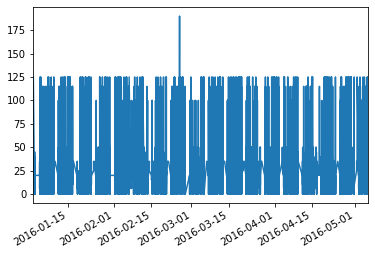

In [12]:
%matplotlib inline
# Now let's plot the fines over the year!
import matplotlib.pyplot as plt
df[" Fine "].plot()

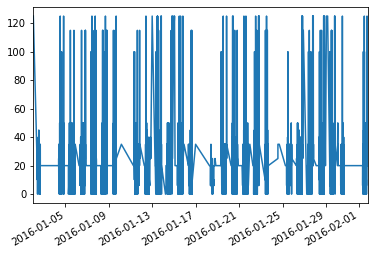

In [13]:
# gah! That's meaningless. How would we find signal in that noise?
# let's zoom in on a single month, pandas does the "right thing" with date/time slicing!
df.loc["2016-01-01":"2016-02-01", " Fine "].plot()

In [14]:
# This, is, btw, much cooler than it seems at first blush, check this out
df.index < "2016-01-03"
# WOW!

array([ True,  True,  True, ..., False, False, False])

In [15]:
# so this means we can use date/times as masks!
df[df.index<"2016-02"].head()

,Ticket #,Badge,Issue Date,IssueTime,Plate,State,Make,Model,Violation,Description,Location,Meter,Fine,Penalty
2016-01-02 11:11:00,2060009973,827,2016-01-02,1111,A27VT,MI,SATU,NaN,A01,EXPIRED METER,LOT 11,5A,20,0
2016-01-02 13:04:00,2060009996,827,2016-01-02,1304,DCZ5024,MI,HOND,NaN,A04,NO PRKNG ANYTME,200 BLK OF STATE SOU,NaN,25,0
2016-01-02 13:02:00,2060009995,827,2016-01-02,1302,BEJ2048,MI,FORD,NaN,A01,EXPIRED METER,900 BLK OF WASHINGTO,5066B,20,0
2016-01-02 12:57:00,2060009994,827,2016-01-02,1257,DKQ9157,MI,FORD,NaN,A01,EXPIRED METER,300 BLK OF THAYER SO,5088,10,0
2016-01-02 12:54:00,2060009993,827,2016-01-02,1254,GJR3356,OH,CHEV,NaN,A01,EXPIRED METER,700 BLK OF WASHINGTO,5046,20,50


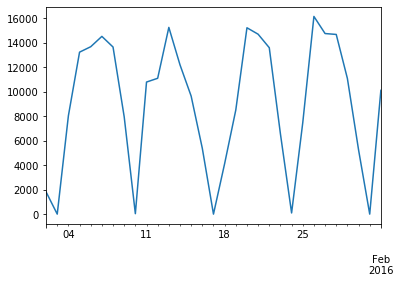

In [16]:
# Now let's resample this and look at daily totals
df.loc["2016-01-01":"2016-02-01", " Fine "].resample("1D").apply(np.sum).plot()

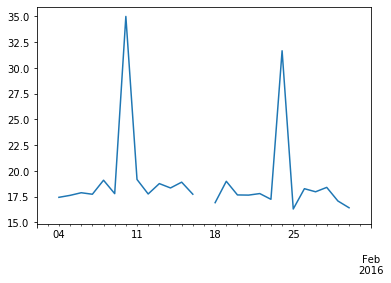

In [17]:
# January 10th 2016 was a sunday! Looks pretty clear that sundays very few tickets 
# are given out!
# Also, David Bowie died on this day. :(
# How do things change if we look at mean values?
df.loc["2016-01-01":"2016-02-01", " Fine "].resample("1D").apply(np.mean).plot()

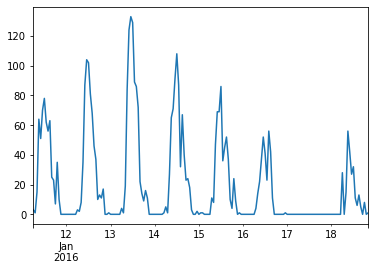

In [18]:
#We could also look at tickets per hour in a single week
df.loc["2016-01-11":"2016-01-18", " Fine "].resample("1H").apply(len).plot()

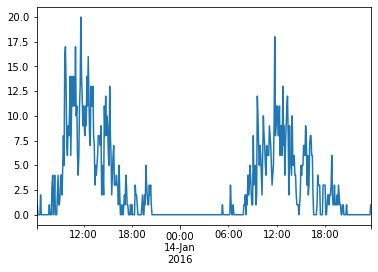

In [20]:
# That 13th-14th has some big values, let's zoom in a bit
df.loc["2016-01-13":"2016-01-14", " Fine "].resample("5T").apply(len).plot()

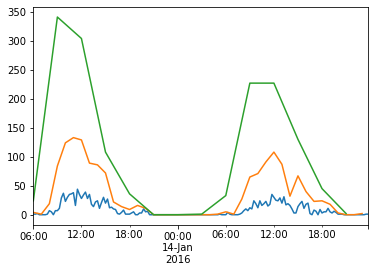

In [21]:
# We can also explore multiple series of data plotted on the same chart by executing plot() on a
# dataframe multiple times in a single cell
df.loc["2016-01-13":"2016-01-14", " Fine "].resample("15T").apply(len).plot()
df.loc["2016-01-13":"2016-01-14", " Fine "].resample("60T").apply(len).plot()
df.loc["2016-01-13":"2016-01-14", " Fine "].resample("180T").apply(len).plot()